In [26]:
import os
import torch
import torch.nn as nn
from breast_cancer_detection.model import myModel
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns



In [47]:
main_dir = "/media/ist/Drive2/MANSOOR/Neuroimaging-Project/Breast_Cancer_Classification_Project"
weights_dir = os.path.join(main_dir, "WSI_Breast_Cancer_Classification/Model_Weights")
model_filenames = {"ResNet18": "ResNet18_best_model_epoch_19.pth", 
                   "ResNet50": "ResNet50_best_model_epoch_14.pth", 
                   "DenseNet" : "DenseNet_best_model_ben_vs_mal.pth"}

cell_multi_class_models_filenames = {"resnet": "resnet_cell_multi_category_classifier.pth",
                                     "vit": "vit_cell_multi_category_classifier.pth"}

pos_neg_dir = f"{main_dir}/Tiles_Data"
ben_mal_dir = f"{main_dir}/Tiles_Data_Cat_Classification"
cell_multi_class_dir = os.path.join(main_dir, "Tiles_Data_Cell_Category_Classification")
batch_size = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = ""

In [48]:
data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }

In [49]:
def load_data(img_files_dir):
    image_datasets = {x: datasets.ImageFolder(os.path.join(img_files_dir, x), data_transforms[x])
                        for x in ['train', 'val']}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
                    for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    return dataloaders, dataset_sizes, class_names

In [44]:
def load_and_evaluate_model(model_path, img_files_dir, model_name, num_classes = 2, phase='val'):
    """Load the saved model and evaluate it on the test set."""
    if model_name == "resnet18":
        model = models.resnet18(pretrained=False) 
        num_ftrs = model.fc.in_features # final layer is fc
        model.fc = nn.Linear(num_ftrs, num_classes ) 

    elif model_name == "resnet50":
        model = models.resnet50(pretrained=False) 
        num_ftrs = model.fc.in_features # final layer is fc
        model.fc = nn.Linear(num_ftrs, num_classes ) 

    elif model_name == "densenet": # custom model
        model = myModel.densenet121()  
        
        num_ftrs = model.classifier.in_features # final layer is classifier
        model.classifier = torch.nn.Linear(num_ftrs, num_classes) # num_classes = 2
    
    elif model_name == 'vit':
        model = models.vit_b_16(pretrained=True)
        num_features = model.heads.head.in_features
        model.heads.head = nn.Linear(num_features, num_classes)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    dataloaders, dataset_sizes, _ = load_data(img_files_dir)

    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())

    return true_labels, predictions

def plot_confusion_matrix(conf_matrix, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def print_classification_report(true_labels, predictions, target_classes):
    report = classification_report(true_labels, predictions, target_names=target_classes, zero_division=0)
    print("Classification Report:\n", report)

def show_classification_results(true_labels, predictions, target_classes):
    # Calculate metrics 
    conf_matrix = confusion_matrix(true_labels, predictions)

    plot_confusion_matrix(conf_matrix, classes=target_classes)
    print_classification_report(true_labels, predictions, target_classes)


Cell category multi-class classification

In [ ]:
####################### ViT #########################
target_classes = ['Blood vessel', 'Immune cells', 'Kayrorrhexis', "Mitosis", "Neuropill", "Red blood cell", "Stroma", "Tumor"]
# target_classes = ['Kayrorrhexis', "Mitosis", "Red blood cell", "Stroma", "Tumor"]

true_labels, predictions = load_and_evaluate_model(f"{weights_dir}/{cell_multi_class_models_filenames["vit"]}",
                                                    cell_multi_class_dir, "vit", num_classes=len(target_classes))
show_classification_results(true_labels, predictions, target_classes)

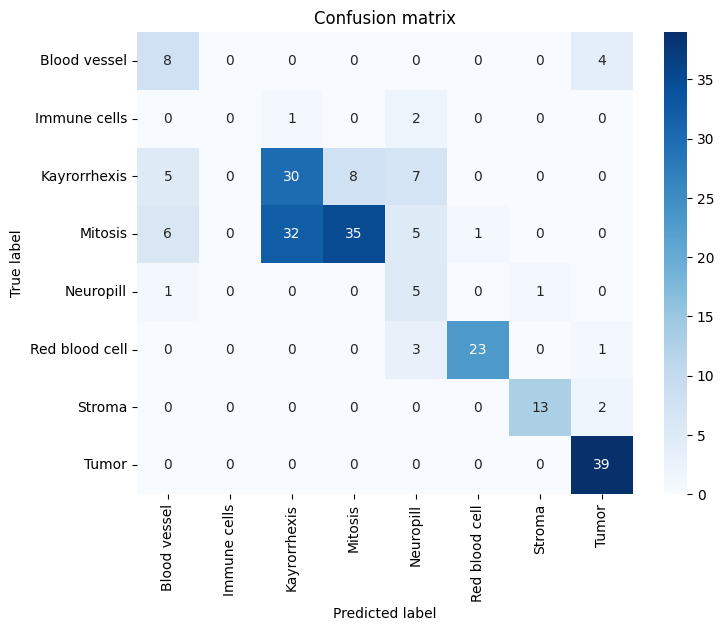

Classification Report:
                 precision    recall  f1-score   support

  Blood vessel       0.40      0.67      0.50        12
  Immune cells       0.00      0.00      0.00         3
  Kayrorrhexis       0.48      0.60      0.53        50
       Mitosis       0.81      0.44      0.57        79
     Neuropill       0.23      0.71      0.34         7
Red blood cell       0.96      0.85      0.90        27
        Stroma       0.93      0.87      0.90        15
         Tumor       0.85      1.00      0.92        39

      accuracy                           0.66       232
     macro avg       0.58      0.64      0.58       232
  weighted avg       0.72      0.66      0.66       232



In [43]:
##################### ResNet ##########################
target_classes = ['Blood vessel', 'Immune cells', 'Kayrorrhexis', "Mitosis", "Neuropill", "Red blood cell", "Stroma", "Tumor"]
# target_classes = ['Kayrorrhexis', "Mitosis", "Red blood cell", "Stroma", "Tumor"]

true_labels, predictions = load_and_evaluate_model(f"{weights_dir}/{cell_multi_class_models_filenames["ResNet50"]}",
                                                    cell_multi_class_dir, "resnet50", num_classes=len(target_classes))
show_classification_results(true_labels, predictions, target_classes)

Breast cancer positive/negative classification results

In [ ]:
true_labels, predictions = load_and_evaluate_model(f"{weights_dir}/{model_filenames["ResNet18"]}", pos_neg_dir, "resnet18")
target_classes = ['Positive', 'Negative']
show_classification_results(true_labels, predictions, target_classes)

/media/ist/Drive2/DL-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/ist/Drive2/DL-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


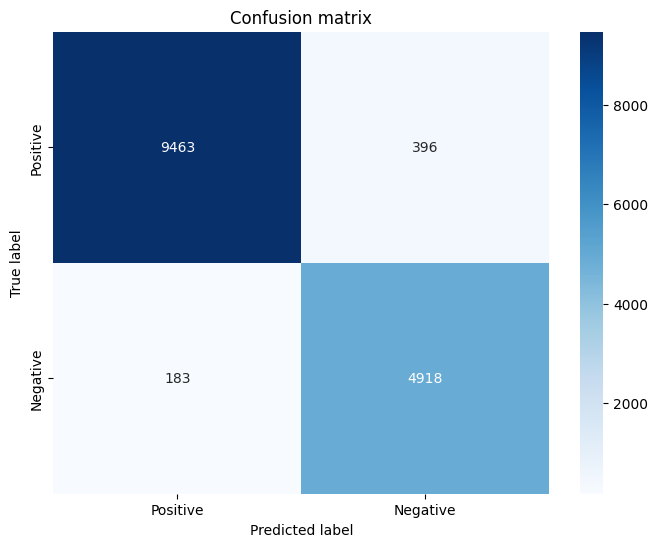

Classification Report:
               precision    recall  f1-score   support

    Positive       0.98      0.96      0.97      9859
    Negative       0.93      0.96      0.94      5101

    accuracy                           0.96     14960
   macro avg       0.95      0.96      0.96     14960
weighted avg       0.96      0.96      0.96     14960



In [49]:
true_labels, predictions = load_and_evaluate_model(f"{weights_dir}/{model_filenames["ResNet50"]}", pos_neg_dir, "resnet50")
target_classes = ['Positive', 'Negative']
show_classification_results(true_labels, predictions, target_classes)

Benign vs malignant breast cancer cell categories

/media/ist/Drive2/DL-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


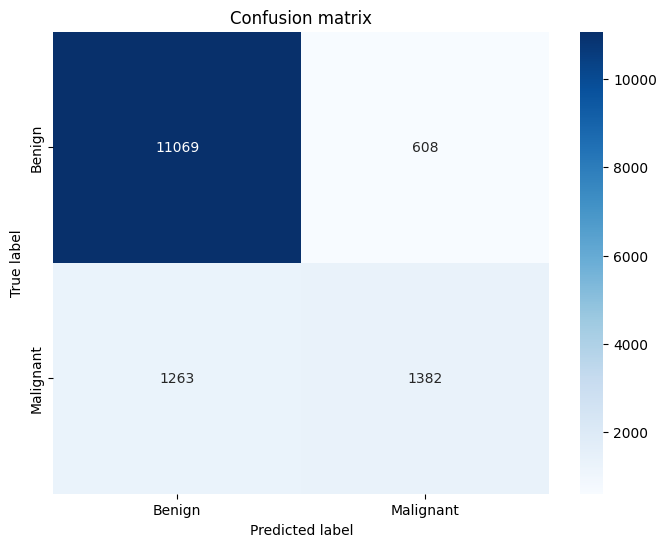

Classification Report:
               precision    recall  f1-score   support

      Benign       0.90      0.95      0.92     11677
   Malignant       0.69      0.52      0.60      2645

    accuracy                           0.87     14322
   macro avg       0.80      0.74      0.76     14322
weighted avg       0.86      0.87      0.86     14322



In [57]:
true_labels, predictions = load_and_evaluate_model(f"{weights_dir}/{model_filenames["DenseNet"]}", ben_mal_dir, "densenet")
target_classes = ['Benign', 'Malignant']
show_classification_results(true_labels, predictions, target_classes)